# Прогнозирование оттока клиентов телеком оператора

## Постановка задачи:

### Цель:
Построить модель, которая предотовратит отток клиентов телеком компаннии за счёт предложения специальных условий

### Описание услуг компании:
Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных:

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

## План работы:
1. [Открытие данных и получение общей информации](#1.-Открытие-данных-и-получение-общей-информации:) <br>
2. [Исследовательский анализ](#2.-Исследовательский-анализ)
3. [Подготовка данных для модели](#3.-Подготовка-данных-для-модели)
4. [Выбор модели машинного обучения для решения задачи](#4.-Выбор-модели-машинного-обучения-для-решения-задачи) <br>
    4.1 [Случайный лес](#4.1-Случайный-лес) <br>
    4.2 [Градиентный бустинг](#4.2-Градиентный-бустинг) <br>
    4.3 [Выбор с сравнение моделей](#4.3-Выбор-с-сравнение-моделей)
5. [Выводы](#5.-Выводы)

## 1. Открытие данных и получение общей информации:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
contract = pd.read_csv('datasets/contract.csv')
personal = pd.read_csv('datasets/personal.csv')
internet = pd.read_csv('datasets/internet.csv')
phone = pd.read_csv('datasets/phone.csv')

Посмотрим общую информацию о каждом датасете:

In [3]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
print('Количество дубликатов:',contract.duplicated().sum())

Количество дубликатов: 0


В этом датасете представлена информация о 7043 заключённых договорах. <br>
Явных ропусков и дубликатов в данных нет. <br>
Описание признаков:
- customerID - код клиента
- BeginDate - дата заключения договора (нужно преобразование типов)
- EndDate - дата расторжения договора ('No', если ещё действует)
- Type -  тип оплаты (ежемесячный или ежегодный)
- PaperlessBilling - выставление электронных счетов
- PaymentMethod - вид оплаты
- MonthlyCharges - ежемесячная плата
- TotalCharges - суммарная оплата

In [6]:
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [7]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
print('Количество дубликатов:',contract.duplicated().sum())

Количество дубликатов: 0


В этом датасете представлена информация о 7043 клиентах. <br>
Явных ропусков и дубликатов в данных нет. <br>
Описание признаков:
- customerID - код клиента
- gender - пол
- SeniorCitizen - признак пожилого клиента
- Partner - партнер
- Dependents - иждивенец


In [9]:
internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
print('Количество дубликатов:',internet.duplicated().sum())

Количество дубликатов: 0


В этом датасете представлена информация о предоставленных интернет-услугах. <br>
Явных ропусков и дубликатов в данных нет. <br>
Описание признаков:
- customerID - код клиента
- InternetService - тип интернет соединения
- OnlineSecurity - услуга блокировки небезопасных сайтов
- OnlineBackup - облачное хранилище файлов для резервного копирования данных
- DeviceProtection - антивирус
- TechSupport - выделенная линия технической поддержки
- StreamingTV - стриминговое телевидение
- StreamingMovies - каталог фильмов

In [12]:
phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [13]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [14]:
print('Количество дубликатов:',phone.duplicated().sum())

Количество дубликатов: 0


В этом датасете представлена информация о предоставленных услугах телефонии. <br>
Явных ропусков и дубликатов в данных нет. <br>
Описание признаков:
- customerID - код клиента
- MultipleLines подключение телефонного аппарата к нескольким линиям одновременно

In [15]:
contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

In [16]:
print((contract['EndDate'] == 'No').sum(), 'клиентов ещё не расторгли договор')

5174 клиентов ещё не расторгли договор


1869 из 7043 клиентов расторгли договор и ушли из компании, предоставленная выборка не сбалансирована

Объединим все данные таблицы и добавим признак наличия телефона у клиента:

In [17]:
phone['is_phone'] = 1

In [18]:
data_full = pd.merge(left=contract, right=personal, on='customerID', how='outer')
data_full = pd.merge(left=data_full, right=internet, on='customerID', how='outer')
data_full = pd.merge(left=data_full, right=phone, on='customerID', how='outer')

Добавим признак *outflow* он будет обозначать - ушел(0) человек из компании или нет(1) (на дату 1 февраля 2020 года):

In [19]:
data_full['outflow'] = data_full['EndDate'].apply(lambda x : 1 if (x == 'No') else 0)

Добавим признак *lifetime* он будет означать, сколько времени клиент находится(-лся) в компании.

In [20]:
data_full['EndDate'] = data_full['EndDate'].apply(lambda x : '2020-02-01 00:00:00' if (x == 'No') else x)
data_full['BeginDate'] = pd.to_datetime(data_full['BeginDate'], format='%Y-%m-%d')
data_full['EndDate'] = pd.to_datetime(data_full['EndDate'], format='%Y-%m-%d %H:%M:%S')
data_full['lifetime'] = (data_full['EndDate'] - data_full['BeginDate']) / np.timedelta64(1, 'D')

Добавим признак *number_of_services*, он будет означать количество подключенных доп услуг (интернет)

In [21]:
def to_num(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0

data_full['OnlineSecurity'] = data_full['OnlineSecurity'].apply(to_num)
data_full['OnlineBackup'] = data_full['OnlineBackup'].apply(to_num)
data_full['DeviceProtection'] = data_full['DeviceProtection'].apply(to_num)
data_full['TechSupport'] = data_full['TechSupport'].apply(to_num)
data_full['StreamingTV'] = data_full['StreamingTV'].apply(to_num)
data_full['StreamingMovies'] = data_full['StreamingMovies'].apply(to_num)
data_full['MultipleLines'] = data_full['MultipleLines'].apply(to_num)

data_full['number_of_services'] = (data_full['OnlineSecurity'] + data_full['OnlineBackup'] + data_full['DeviceProtection'] + 
                                   data_full['TechSupport'] + data_full['StreamingTV'] + data_full['StreamingMovies'])
data_full['number_of_services'] = data_full['number_of_services'].fillna(0)

In [22]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customerID          7043 non-null   object        
 1   BeginDate           7043 non-null   datetime64[ns]
 2   EndDate             7043 non-null   datetime64[ns]
 3   Type                7043 non-null   object        
 4   PaperlessBilling    7043 non-null   object        
 5   PaymentMethod       7043 non-null   object        
 6   MonthlyCharges      7043 non-null   float64       
 7   TotalCharges        7043 non-null   object        
 8   gender              7043 non-null   object        
 9   SeniorCitizen       7043 non-null   int64         
 10  Partner             7043 non-null   object        
 11  Dependents          7043 non-null   object        
 12  InternetService     5517 non-null   object        
 13  OnlineSecurity      5517 non-null   float64     

### Выводы:
Полученный датасет достаточно чистый и в кардинальной подготовке данных не нуждается

## 2. Исследовательский анализ

Проведём исследовательский анализ данных и посмотрим на некоторые возможные зависимости:

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

Распределение "времени жизни" клиентов оставшихся в компании (1) и тех, кто расторг договор (0):

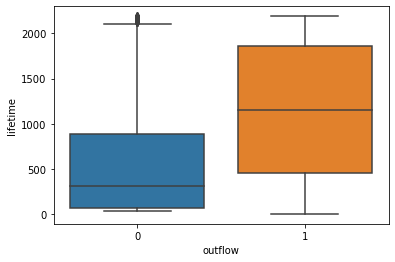

In [24]:
sns.boxplot(x='outflow', y='lifetime', data=data_full.loc[:, ['lifetime', 'outflow']])

Явно видно, что более старые клиенты меньше покидают компанию

Посмотрим, как распределена месячная плата у тех, кто остался и у тех, кто ушёл:

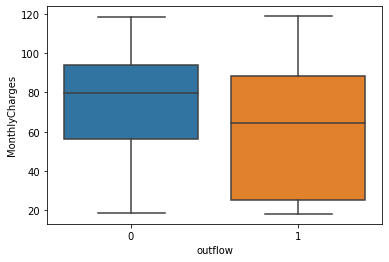

In [25]:
sns.boxplot(x='outflow', y='MonthlyCharges', data=data_full.loc[:, ['MonthlyCharges', 'outflow']])

Среди тех, кто остаётся клиентами компании, больше тех, кто платит меньше. <br>
Видимо, в компании выгодные недорогие тарифы, а вот на дорогих тарифах людям чего-то нехватает. Или используются навязанные услуги

Посмотрим, какой технологией доступа пользуются клиенты:

Распределение технологий у клиентов, покинувших компанию


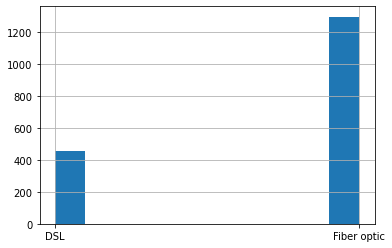

In [26]:
data_full[data_full['outflow'] == 0]['InternetService'].hist();
print('Распределение технологий у клиентов, покинувших компанию')

Распределение технологий у клиентов, оставшихся в компании


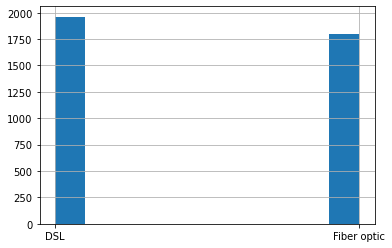

In [27]:
data_full[data_full['outflow'] == 1]['InternetService'].hist();
print('Распределение технологий у клиентов, оставшихся в компании')

Среди тех, кто расторг договор, преобладают клиенты с подключением по оптоволокну - их 74%, а у оставшихся клиентов технологии подключения к интернету распределились поровну.
Возможно там, где доступ в интернет предоставляется по технологии DSL нет конкуренции или она мала. Возможно проблемы с качетсвом предоставляемых услуг по оптоволокну.

Посмотрим, одинаков ли отток клиентов разного пола и пользующихся разными типами оплаты:

Пол клиентов, покинувших компанию


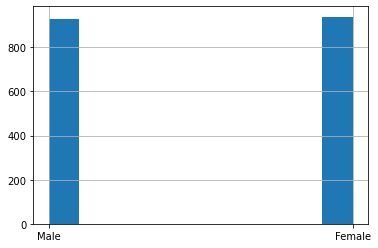

In [28]:
data_full[data_full['outflow'] == 0]['gender'].hist();
print('Пол клиентов, покинувших компанию')

Пол клиентов, оставшихся в компании


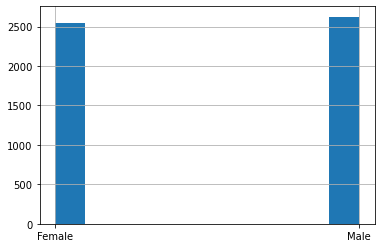

In [29]:
data_full[data_full['outflow'] == 1]['gender'].hist();
print('Пол клиентов, оставшихся в компании')

Метод оплаты клиентов, покинувших компанию


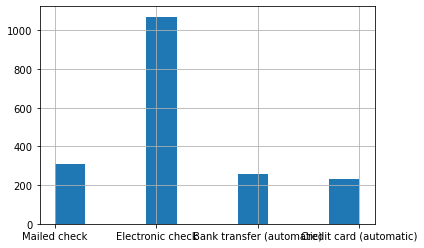

In [30]:
data_full[data_full['outflow'] == 0]['PaymentMethod'].hist();
print('Метод оплаты клиентов, покинувших компанию')

Метод оплаты клиентов, оставшихся в компании


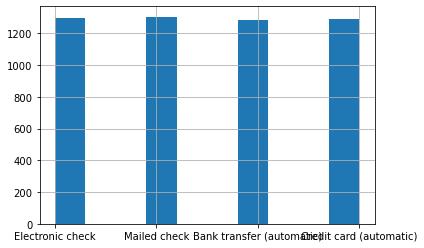

In [31]:
data_full[data_full['outflow'] == 1]['PaymentMethod'].hist();
print('Метод оплаты клиентов, оставшихся в компании')

Клиенты разного пола уходят с одинаковой вероятностью, но из тех, кто расторг договор, больше тех, кто пользуется электронными чеками

Посмотрим, коррелирует ли получение бумажных квитанций с тем, что клиент является пожилым человеком:

Частота получения бумажных квитанций пожилыми людьми:


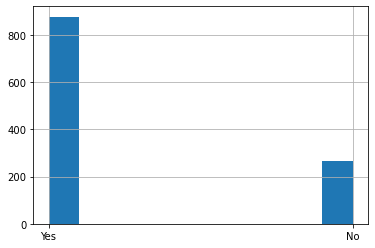

In [32]:
data_full[data_full['SeniorCitizen'] == 1]['PaperlessBilling'].hist();
print('Частота получения бумажных квитанций пожилыми людьми:')

Частота получения бумажных квитанций молодыми людьми:


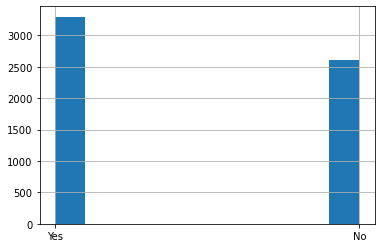

In [33]:
data_full[data_full['SeniorCitizen'] == 0]['PaperlessBilling'].hist();
print('Частота получения бумажных квитанций молодыми людьми:')

Да, пожилые клиенты чаще пользуются бумажными квитанциями, эти признаки коррелируют

Посмотри на корелляцию признаков:

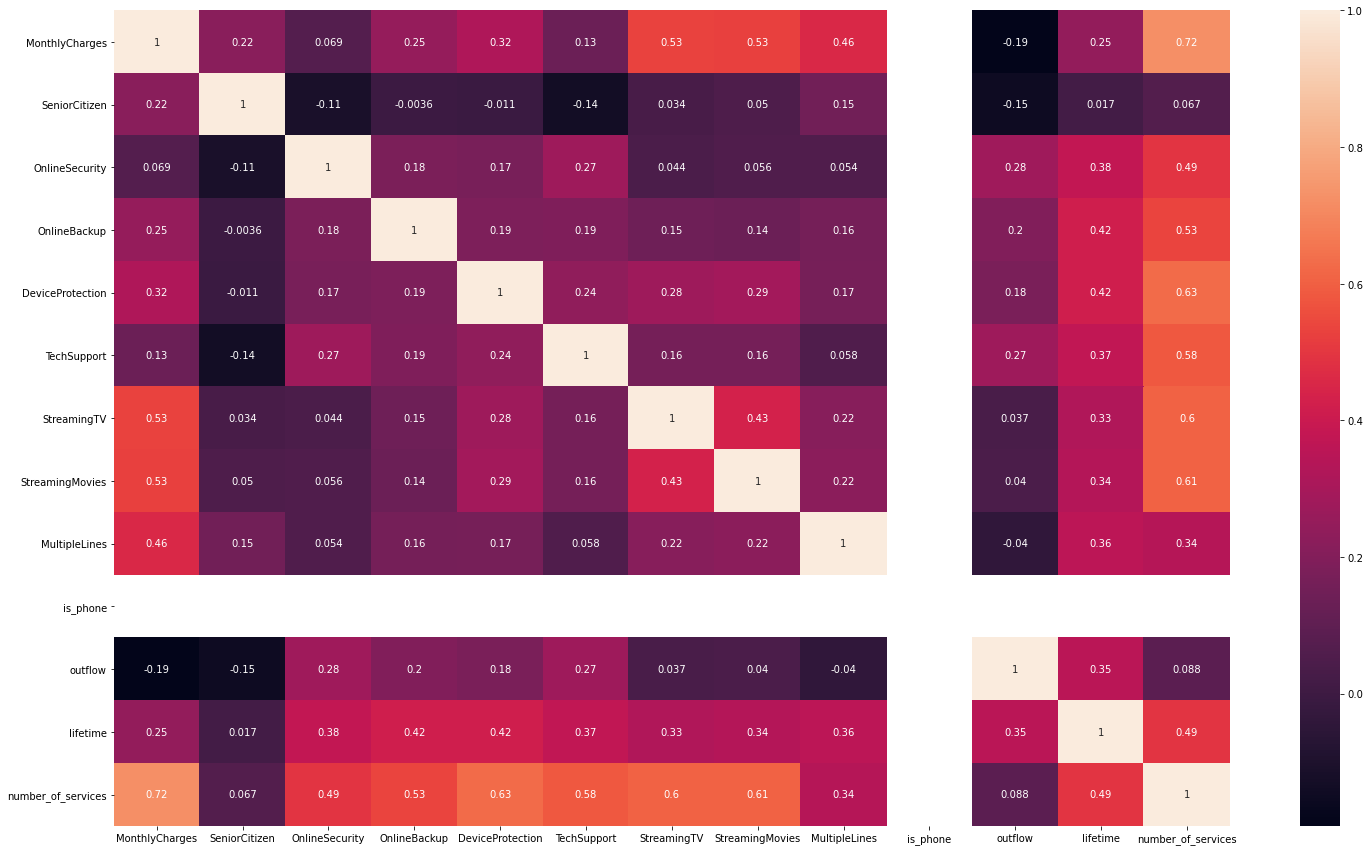

In [34]:
plt.figure(figsize=(25, 15));
sns.heatmap(data_full.corr(), annot=True)

Очевидно что на ежемесячную плату влияет количество подключенных инетрнет услуг. Вероятно самые дорогие из них это стриминговое ТВ и каталог фильмов, а самая частая услуга - это выделенная линия технической поддержки и стриминговое ТВ. <br>
Суммарная оплата сильно коррелирует с ежемесячной оплатой и "временем жизни" договора. Этот признак лучше удалить в будущем

### Выводы:
В ходе исследовательского анализа данных найдены признаки явно влияющие на отток (например, время которое клиент является клиентом компании) и коррелирующие признаки (частота получения бумажных квитанций и возраст), которые не стоит использовать совместно. При необходимости принятия каких либо управленческих решений можно проверить гипотезы о влиянии факторов

## 3. Подготовка данных для модели

In [35]:
from sklearn.model_selection import train_test_split

Удалим явно ненужные и коррелированные признаки:

In [36]:
data_full = data_full.drop(['customerID', 'BeginDate', 'EndDate', 'TotalCharges'], axis=1)

Определим важные признаки для модели градиентного бустинга:

In [37]:
def to_str(x):
    if x == 1:
        return "Yes"
    elif x == 0:
        return "No"
    else:
        return "None"

features_to_nan = ['is_phone', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                  'StreamingTV', 'StreamingMovies', 'MultipleLines']

for i in features_to_nan:
    data_full[i] = data_full[i].fillna('nan')
    data_full[i] = data_full[i].apply(to_str)
    
data_full['InternetService'] = data_full['InternetService'].fillna('nan')
data_full['number_of_services'] = data_full['number_of_services'].fillna(0)
data_full['SeniorCitizen'] = data_full['SeniorCitizen'].apply(to_str)


In [38]:
target = data_full['outflow']
features = data_full.drop('outflow', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                              test_size=0.2,
                                                                              random_state=42)

In [39]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [40]:
model_catboost = CatBoostClassifier(loss_function="Logloss", 
                                    custom_metric='AUC',
                                    random_seed=42, 
                                    task_type='GPU', 
                                    auto_class_weights='Balanced', 
                                    #verbose=False,
                                    iterations=1000,
                                    use_best_model=True,
                                   )
model_catboost.fit(features_train, target_train, cat_features=['Type', 'PaperlessBilling', 'PaymentMethod', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'is_phone'], eval_set=(features_valid, target_valid))

print('ROC AUC для градиентного бустинга CatBoost : {:.3}'.format(roc_auc_score(target_valid, model_catboost.predict(features_valid))))


Learning rate set to 0.061476
0:	learn: 0.6699465	test: 0.6676025	best: 0.6676025 (0)	total: 62.7ms	remaining: 1m 2s
1:	learn: 0.6488392	test: 0.6457431	best: 0.6457431 (1)	total: 123ms	remaining: 1m 1s
2:	learn: 0.6318993	test: 0.6280322	best: 0.6280322 (2)	total: 189ms	remaining: 1m 2s
3:	learn: 0.6177341	test: 0.6122652	best: 0.6122652 (3)	total: 251ms	remaining: 1m 2s
4:	learn: 0.6049344	test: 0.5986444	best: 0.5986444 (4)	total: 314ms	remaining: 1m 2s
5:	learn: 0.5932103	test: 0.5863945	best: 0.5863945 (5)	total: 372ms	remaining: 1m 1s
6:	learn: 0.5824941	test: 0.5749364	best: 0.5749364 (6)	total: 431ms	remaining: 1m 1s
7:	learn: 0.5736519	test: 0.5657711	best: 0.5657711 (7)	total: 498ms	remaining: 1m 1s
8:	learn: 0.5663114	test: 0.5577035	best: 0.5577035 (8)	total: 569ms	remaining: 1m 2s
9:	learn: 0.5586588	test: 0.5502740	best: 0.5502740 (9)	total: 630ms	remaining: 1m 2s
10:	learn: 0.5524720	test: 0.5436527	best: 0.5436527 (10)	total: 695ms	remaining: 1m 2s
11:	learn: 0.5471867	

In [41]:
temp_data = pd.DataFrame(columns=['col', 'data'], data=np.column_stack((np.array(features_train.columns), model_catboost.feature_importances_))).sort_values(by='data', ascending=True)

<Figure size 432x288 with 0 Axes>

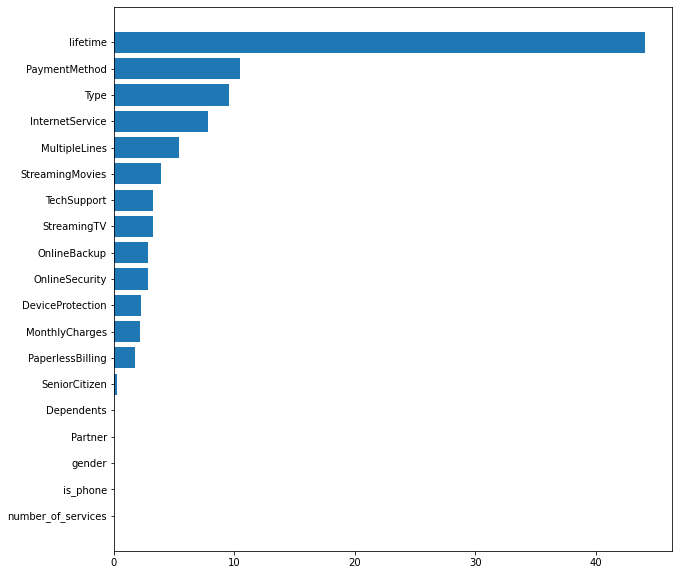

In [42]:
plt.figure()
plt.figure(figsize=(10, 10))
plt.barh(temp_data['col'], temp_data['data'])
plt.show()

Уберём из данных не значащие признаки:

In [43]:
data_full = data_full.drop(['Dependents', 'Partner', 'gender', 'is_phone', 'number_of_services'], axis=1)

----------

Закодируем признаки и разделим выборку на обучающую и тестовую:

In [44]:
data_ohe = pd.get_dummies(data_full, drop_first=True, columns=[
    'Type', 
    'PaymentMethod', 
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup',
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies',
    'MultipleLines', 
    'outflow',
    'PaperlessBilling',
    'SeniorCitizen'])

In [45]:
target = data_ohe['outflow_1']
features = data_ohe.drop('outflow_1', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                              test_size=0.2,
                                                                              random_state=42)

In [46]:
features.head()

,MonthlyCharges,lifetime,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_nan,OnlineSecurity_None,...,TechSupport_None,TechSupport_Yes,StreamingTV_None,StreamingTV_Yes,StreamingMovies_None,StreamingMovies_Yes,MultipleLines_None,MultipleLines_Yes,PaperlessBilling_Yes,SeniorCitizen_Yes
0,29.85,31.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,56.95,1036.0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,53.85,61.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,42.30,1371.0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,70.70,61.0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


### Выводы: 
Данные подготовлены: добавлены новые фичи, категориальные закодированы OHE, произведена обработка пропусков. Теперь данные можно использовать для обучения и проверки моделей.

## 4. Выбор модели машинного обучения для решения задачи

### 4.1 Случайный лес

Попробуем применить модель случайного леса

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [48]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 2142 to 860
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         5634 non-null   float64
 1   lifetime                               5634 non-null   float64
 2   Type_One year                          5634 non-null   uint8  
 3   Type_Two year                          5634 non-null   uint8  
 4   PaymentMethod_Credit card (automatic)  5634 non-null   uint8  
 5   PaymentMethod_Electronic check         5634 non-null   uint8  
 6   PaymentMethod_Mailed check             5634 non-null   uint8  
 7   InternetService_Fiber optic            5634 non-null   uint8  
 8   InternetService_nan                    5634 non-null   uint8  
 9   OnlineSecurity_None                    5634 non-null   uint8  
 10  OnlineSecurity_Yes                     5634 non-null   uint8  
 11  On

In [49]:
%%time

model_forest_RS = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
param_grid = {
    'n_estimators' : [i for i in range(50,300)],
    'max_depth' : [i for i in range(3,20)],
    'max_features' : [i for i in range(10, 22)]
}

CV_model_forest_RS = RandomizedSearchCV(estimator=model_forest_RS, param_distributions=param_grid, cv= 5, scoring='roc_auc', n_jobs=-1, n_iter=300)
CV_model_forest_RS.fit(features_train, target_train)
CV_model_forest_RS.best_params_

print('Лучшее значение ROC AUC случайного леса при кросс-валидации: ', CV_model_forest_RS.best_score_)
print('Лучший результат при проверке модели случайного леса получен при: n_estimators = {:}, max_depth = {:}, max_features = {:}'
      .format(CV_model_forest_RS.best_params_['n_estimators'], CV_model_forest_RS.best_params_['max_depth'], CV_model_forest_RS.best_params_['max_features']))

Лучшее значение ROC AUC случайного леса при кросс-валидации:  0.8644003297730094
Лучший результат при проверке модели случайного леса получен при: n_estimators = 129, max_depth = 10, max_features = 21
Wall time: 6min 12s


In [50]:
%%time

model_forest_RS = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
param_grid = {
    'n_estimators' : [i for i in range(270, 360, 20)],
    'max_depth' : [i for i in range(7,13)],
    'max_features' : [i for i in range(18, 22)]
}

CV_model_forest_RS = GridSearchCV(estimator=model_forest_RS, param_grid=param_grid, cv= 5, scoring='roc_auc', n_jobs=-1)
CV_model_forest_RS.fit(features_train, target_train)
CV_model_forest_RS.best_params_

print('Лучшее значение ROC AUC случайного леса при кросс-валидации: ', CV_model_forest_RS.best_score_)
print('Лучший результат при проверке модели случайного леса получен при: n_estimators = {:}, max_depth = {:}, max_features = {:}'
      .format(CV_model_forest_RS.best_params_['n_estimators'], CV_model_forest_RS.best_params_['max_depth'], CV_model_forest_RS.best_params_['max_features']))

Лучшее значение ROC AUC случайного леса при кросс-валидации:  0.8644555546588174
Лучший результат при проверке модели случайного леса получен при: n_estimators = 270, max_depth = 9, max_features = 20
Wall time: 4min 51s


### 4.2 Градиентный бустинг

Попробуем использовать модель градиентного бустинга для решения задачи. Воспользуемся *lightGBM* с параметрами "из коробки":

In [51]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

In [52]:
%%time

model_lgbm = LGBMClassifier(n_jobs=-1, random_state=43, class_weight='balanced')
param_grid = {
    'learning_rate' : [i for i in np.arange(0.15,0.25,0.001)]
}

CV_model_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, cv= 5, scoring='roc_auc', n_jobs=-1)
CV_model_lgbm.fit(features_train, target_train)
CV_model_lgbm.best_params_

print('Лучшее значение ROC AUC для градиентного бустинга lightgbm на кросс-валидации: ', CV_model_lgbm.best_score_)
print('Лучшее значение ROC AUC для градиентного бустинга lightgbm получено при learning_rate: ', CV_model_lgbm.best_params_['learning_rate'])

Лучшее значение ROC AUC для градиентного бустинга lightgbm на кросс-валидации:  0.8960045633616904
Лучшее значение ROC AUC для градиентного бустинга lightgbm получено при learning_rate:  0.19100000000000003
Wall time: 15.8 s


In [53]:
model_lgbm = LGBMClassifier(n_jobs=-1, random_state=43, class_weight='balanced', learning_rate=0.19)
model_lgbm.fit(features_train, target_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.19, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective=None, random_state=43,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

Воспользуемся *CatBoost'ом*:

In [54]:
from catboost import CatBoostClassifier
from catboost import Pool, cv

In [55]:
cat_features = ['Type_One year', 'Type_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_nan',
       'OnlineSecurity_None', 'OnlineSecurity_Yes', 'OnlineBackup_None',
       'OnlineBackup_Yes', 'DeviceProtection_None', 'DeviceProtection_Yes',
       'TechSupport_None', 'TechSupport_Yes', 'StreamingTV_None',
       'StreamingTV_Yes', 'StreamingMovies_None', 'StreamingMovies_Yes',
       'MultipleLines_None', 'MultipleLines_Yes', 'PaperlessBilling_Yes',
       'SeniorCitizen_Yes']

Подберём гиперпараметры графически:

In [72]:
grid = {'iterations': [i for i in range(1000, 1700, 100)],
        'learning_rate': [i for i in np.arange(0.03, 0.05, 0.002)],
        'depth': [8, 9, 10, 11, 12],
        'l2_leaf_reg': [3, 4, 5, 6],
       'random_strength': [0.5, 1.0, 10],
       'bagging_temperature':[0.5, 0.75, 1]}


model_catboost = CatBoostClassifier(loss_function="Logloss", 
                                    custom_metric='AUC',
                                    random_seed=42, 
                                    task_type='GPU', 
                                    auto_class_weights='Balanced', 
                                    verbose=False,
                                    #iterations=1000
                                   )

randomized_search_result = model_catboost.randomized_search(grid,
                                                   X=features_train,
                                                   y=target_train,
                                                   plot=True, n_iter=300)


#model_catboost.fit(features_train, target_train, cat_features=cat_features, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.3536433798
bestIteration = 982
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.3536434	best: 0.3536434 (0)	total: 45.1s	remaining: 3h 44m 46s
bestTest = 0.3664008235
bestIteration = 841
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.3664008	best: 0.3536434 (0)	total: 1m 36s	remaining: 3h 59m 28s
bestTest = 0.3679994874
bestIteration = 971
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.3679995	best: 0.3536434 (0)	total: 2m 22s	remaining: 3h 55m 19s
bestTest = 0.3650082196
bestIteration = 992
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.3650082	best: 0.3536434 (0)	total: 3m 14s	remaining: 

Параметры подобраны:
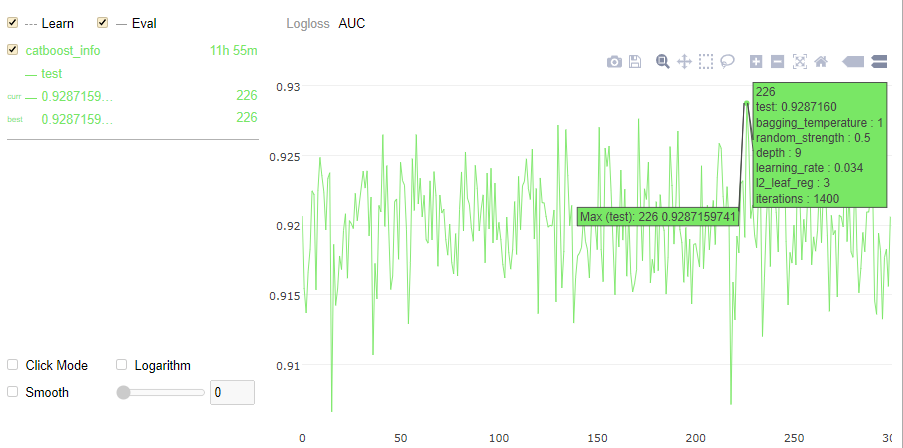

В итоге важность признаков распределилась таким образом:

<Figure size 432x288 with 0 Axes>

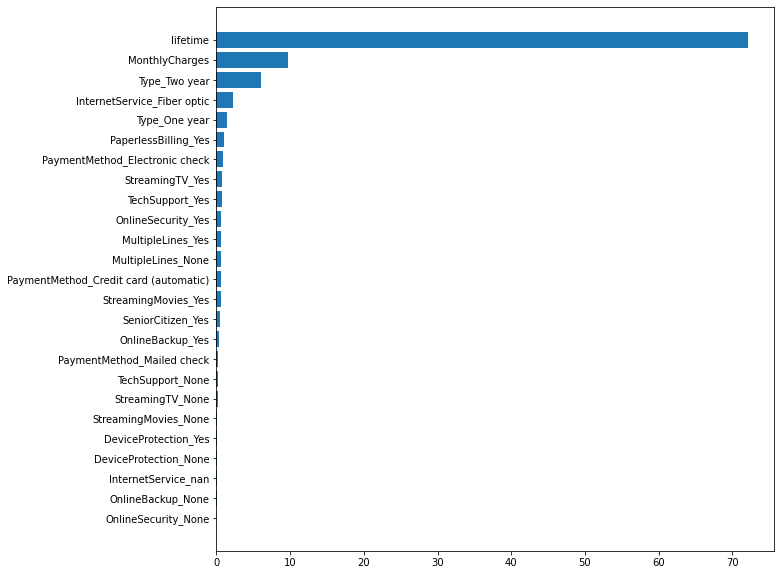

In [78]:
temp_data = pd.DataFrame(columns=['col', 'data'], data=np.column_stack((np.array(features_train.columns), model_catboost.feature_importances_))).sort_values(by='data', ascending=True)
plt.figure()
plt.figure(figsize=(10, 10))
plt.barh(temp_data['col'], temp_data['data'])
plt.show()

Наибольшее влияние на решение клиентов покинуть компанию оказывают такие факторы, как время нахождения в компании, ежемесячный платёж, тип заключения договора (год или два), тип интернет соединения.

### 4.3 Выбор с сравнение моделей

In [80]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score

Построим ROC кривую:

<Figure size 432x288 with 0 Axes>

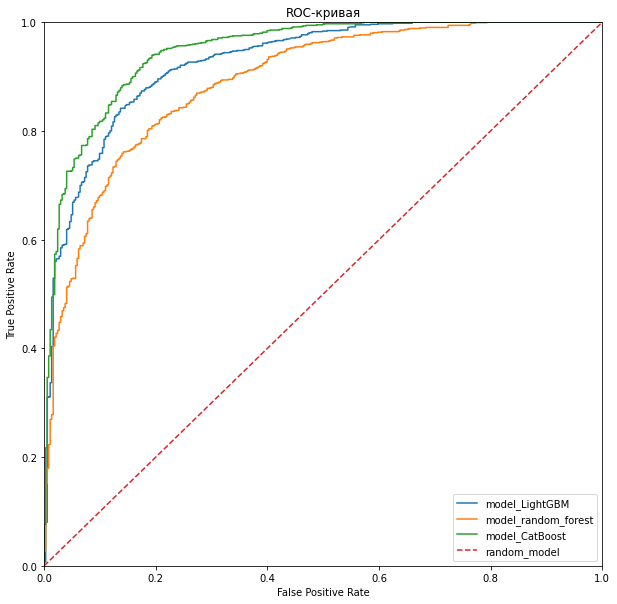

In [83]:
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(target_valid, model_lgbm.predict_proba(features_valid)[:, 1])
fpr_forest, tpr_forest, thresholds_forest = roc_curve(target_valid, CV_model_forest_RS.predict_proba(features_valid)[:, 1])
fpr_catboost, tpr_catboost, thresholds_catboost = roc_curve(target_valid, model_catboost.predict_proba(features_valid)[:, 1])

plt.figure()
plt.figure(figsize=(10, 10))
# графики моделей
plt.plot(fpr_lgbm, tpr_lgbm)
plt.plot(fpr_forest, tpr_forest)
plt.plot(fpr_catboost, tpr_catboost)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend(['model_LightGBM', 'model_random_forest', 'model_CatBoost', 'random_model'])
plt.show()

Посчитаем значение ROC AUC моделей на тестовой выборке:

In [76]:
print('ROC AUC для градиентного бустинга lightgbm: {:.3}'.format(roc_auc_score(target_valid, model_lgbm.predict(features_valid))))
print('ROC AUC для случайного леса : {:.3}'.format(roc_auc_score(target_valid, CV_model_forest_RS.predict(features_valid))))
print('ROC AUC для градиентного бустинга CatBoost : {:.3}'.format(roc_auc_score(target_valid, model_catboost.predict(features_valid))))

ROC AUC для градиентного бустинга lightgbm: 0.847
ROC AUC для случайного леса : 0.805
ROC AUC для градиентного бустинга CatBoost : 0.87


Лучше остальных себя показала модель градиентного бустинга *CatBoost*. Она оказалась наиболее точной и работает быстро, именно её можно прменять для предсказания оттока клиентов в компании.

Посчитаем *accuracy* модели:

In [77]:
print('CatBoost accuracy = {:.3}'.format(accuracy_score(target_valid, model_catboost.predict(features_valid))))

CatBoost accuracy = 0.872


Посчитаем полноту и точность модели:

In [82]:
print('CatBoost полнота = {:.2}'.format(recall_score(target_valid, model_catboost.predict(features_valid))))
print('CatBoost точность = {:.2}'.format(precision_score(target_valid, model_catboost.predict(features_valid))))

CatBoost полнота = 0.87
CatBoost точность = 0.95


## 5. Выводы

В результате работы получили модель градиентного бустинга для предсказания оттока клиентов компании с *ROC AUC = 0.87* и *accuracy = 0.872*. По построеной кривой ROC AUC можно выбрать необходимый порог для минимизации потерь (расходы на удержание клиентов и потери от ухода клиентов).